## daily data updates for the helioforecast.space website

Main author: C. Möstl, Austrian Space Weather Office, GeoSphere Austria

https://github.com/cmoestl/heliocats

uses environment 'envs/env_helio4.yml'


In [11]:
# https://github.com/cmoestl/heliocats  data_update_web.py

# for updating data every day on the servers

import pickle
import importlib
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import sys
import numpy as np
import datetime
import scipy.signal
import urllib
import json
import os   
import time
import h5py
import pytz
import copy
import cdflib

from heliocats import data as hd
from heliocats import plot as hp


##### check for system type
#server
if sys.platform == 'linux': 
    print('system is linux')
    matplotlib.use('Agg') 
#mac
if sys.platform =='darwin':  
    print('system is mac')
    %matplotlib inline     



################################################ CHECK  ##############################################
os.system('jupyter nbconvert --to script data_update_web.ipynb')   

#switches
debug_mode=0


#switches
get_omni=1
get_noaa=1
get_wind=1
get_stereoa=1

####################################################################################################################


#test execution times
t0all = time.time()


system is mac


[NbConvertApp] Converting notebook data_update_web.ipynb to script
[NbConvertApp] Writing 8705 bytes to data_update_web.py


### Configure paths depending on server or local machine


In [12]:
if sys.platform == 'linux': 
    
    from config_server import data_path
    from config_server import noaa_path
    from config_server import wind_path
    from config_server import stereoa_path
    from config_server import data_path_ml
    
if sys.platform =='darwin':  

    from config_local import data_path
    from config_local import noaa_path
    from config_local import wind_path
    from config_local import stereoa_path
    from config_local import data_path_ml

print(' ')
print('------ PATHS ')

print(data_path)
print(noaa_path)
print(wind_path)
print(stereoa_path)
print(data_path_ml)


plot_path=data_path+'plots/'
position_path=data_path+'plots_positions/'
sun_path=data_path+'plots_sun/'

print(plot_path)
print(position_path)



########### make directories first time
if os.path.isdir(plot_path) == False: os.mkdir(plot_path)
if os.path.isdir(plot_path+'omni2') == False: os.mkdir(plot_path+'omni2')
if os.path.isdir(plot_path+'wind') == False: os.mkdir(plot_path+'wind')
if os.path.isdir(plot_path+'stereoa') == False: os.mkdir(plot_path+'stereoa')
if os.path.isdir(plot_path+'combined') == False: os.mkdir(plot_path+'combined')


if os.path.isdir(position_path) == False: os.mkdir(position_path)
if os.path.isdir(sun_path) == False: os.mkdir(sun_path)
if os.path.isdir(noaa_path) == False: os.mkdir(noaa_path)
if os.path.isdir(data_path_ml) == False: os.mkdir(data_path_ml)

 
------ PATHS 
/Users/chris/python/data/insitu_python/
/Users/chris/python/ops/data/noaa/
/Users/chris/python/data/wind/
/Users/chris/python/data/stereoa/
/Users/chris/python/data/insitu_python/ML_struct_arrays/
/Users/chris/python/data/insitu_python/plots/
/Users/chris/python/data/insitu_python/plots_positions/


## Development cells

### positions and SDO plot

 
------ POSITIONS 


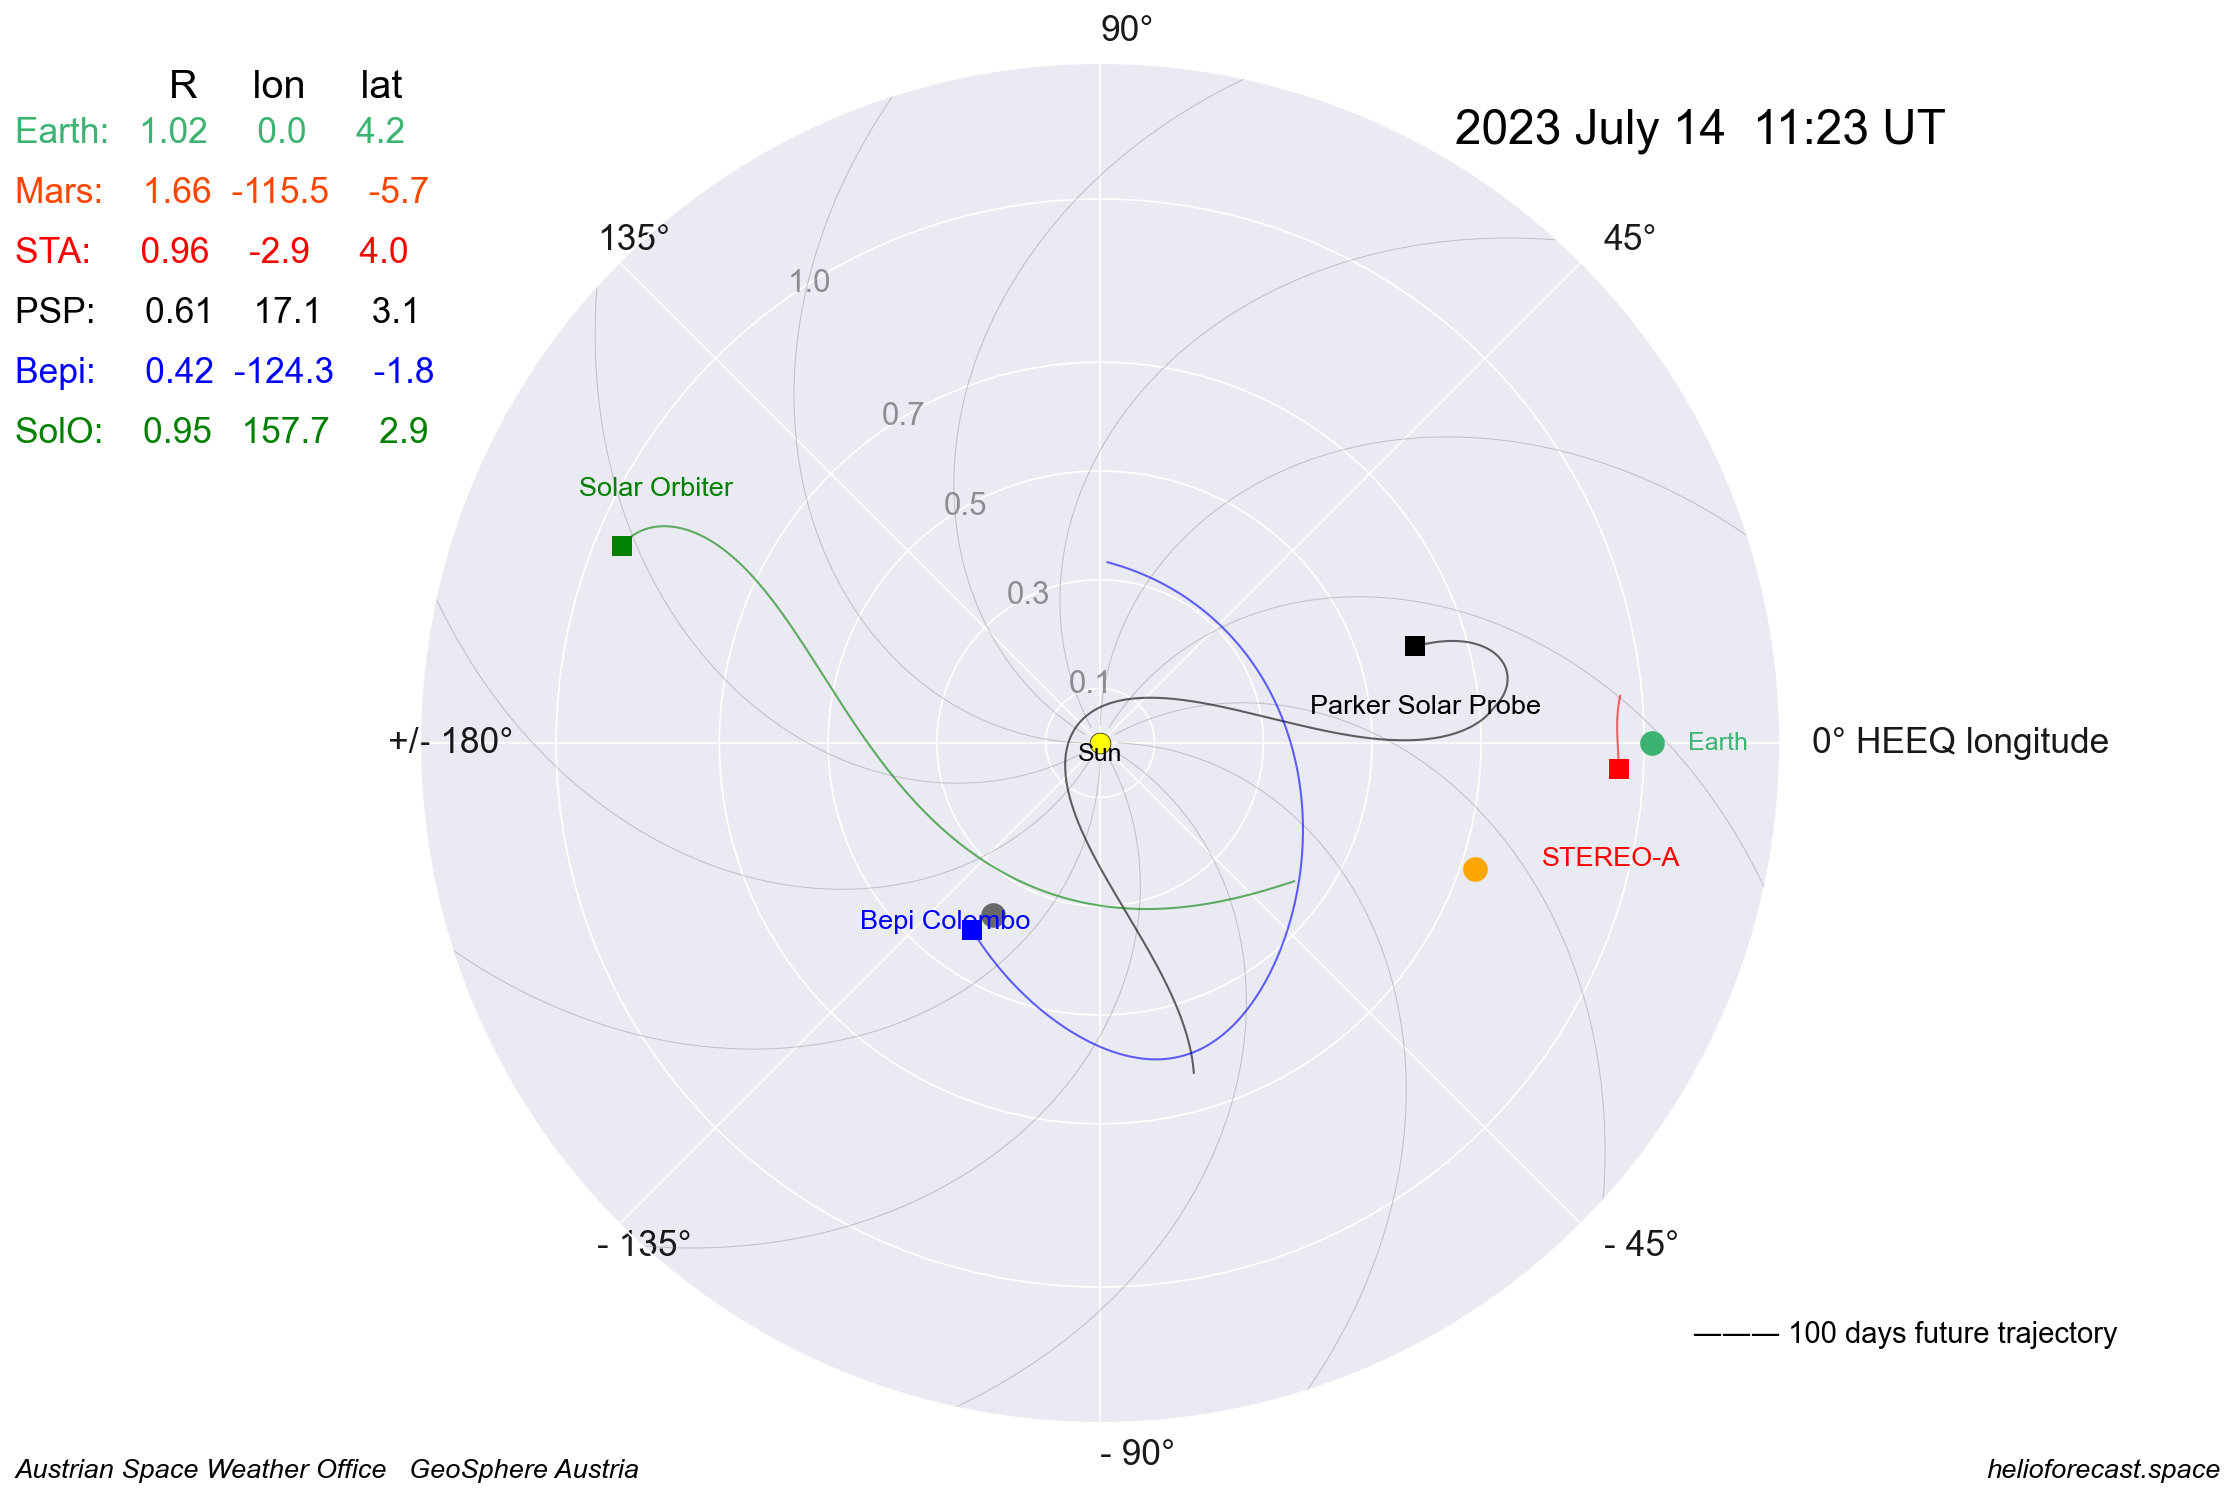

saved as  /Users/chris/python/data/insitu_python/plots_positions/positions_2023_Jul_14.png
saved as  /Users/chris/python/data/insitu_python/plots_positions/positions_now.png
 
------ SDO realtime images 
saved  /Users/chris/python/data/insitu_python/plots_sun/latest_1024_0193.jpg
saved  /Users/chris/python/data/insitu_python/plots_sun/latest_1024_HMIB.jpg

Positions and SDO images takes 2.34 seconds


In [4]:
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 


t0 = time.time()
print(' ')
print('------ POSITIONS ')

# spacecraft positions image
hp.plot_positions(datetime.datetime.utcnow(),position_path, 'HEEQ',now=True)

print(' ')
print('------ SDO realtime images ')
# get current SDO images 
hd.get_sdo_realtime_image(sun_path)




t1 = time.time()
print()
print('Positions and SDO images takes', np.round(t1-t0,2), 'seconds')

### OMNI2 data


 
------ OMNI2 
start omni
load OMNI2 .dat into "data" directory from
https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/omni2_all_years.dat
534720  datapoints
position start
position end 
done omni

saved as  /Users/chris/python/data/insitu_python/plots/omni2/OMNI2_2022_Jul_14_2023_Jul_14.png
saved as  /Users/chris/python/data/insitu_python/plots/omni2/OMNI2_2022_Jul_14_2023_Jul_14.pdf
saved as  /Users/chris/python/data/insitu_python/plots/omni2/OMNI2_now.png
saved as  /Users/chris/python/data/insitu_python/plots/omni2/OMNI2_now.pdf


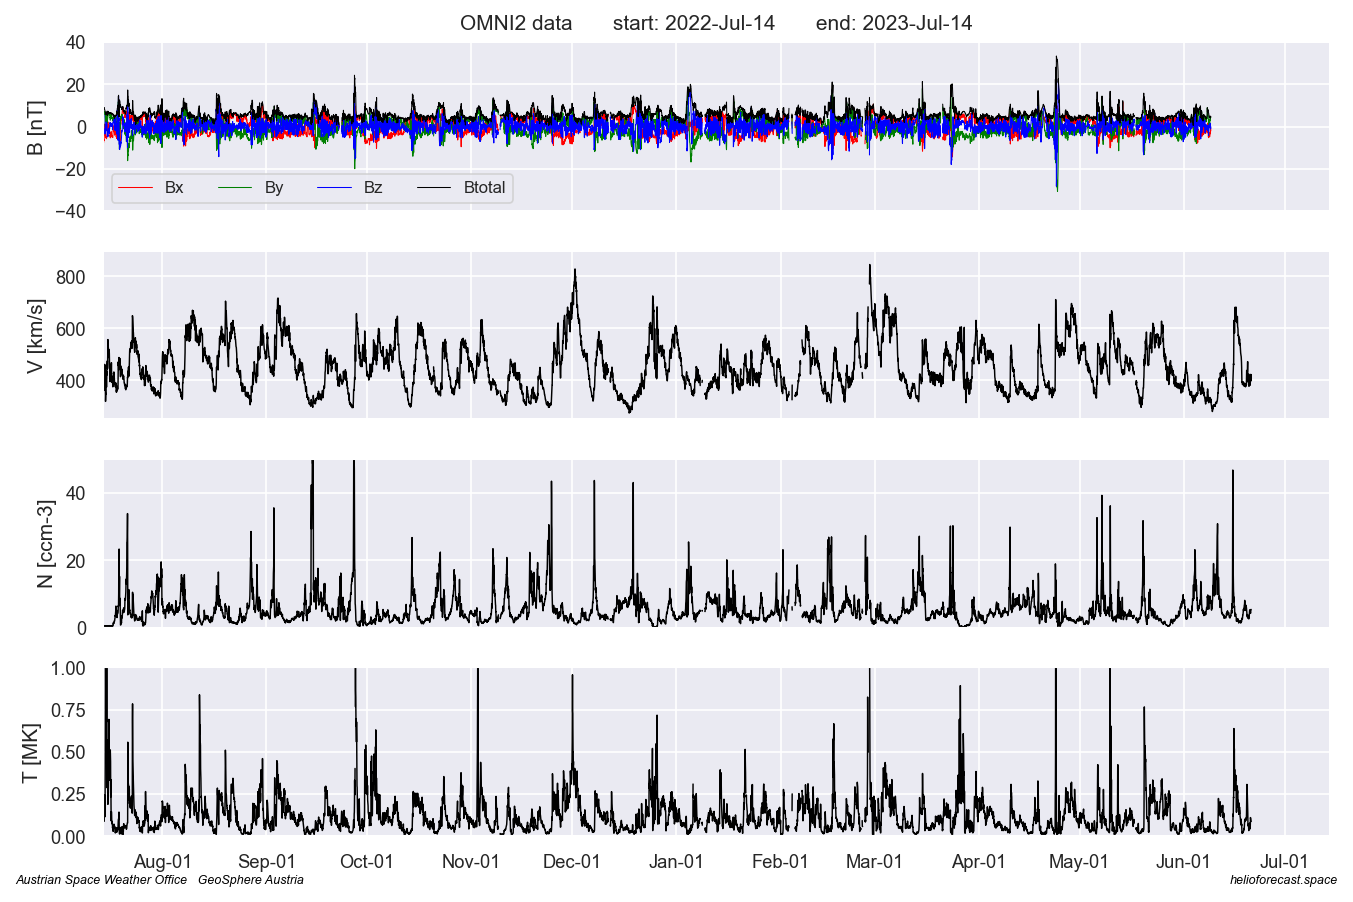

In [5]:
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 
    
print(' ')
print('------ OMNI2 ')


# OMNI2
fileomni="omni_1963_now.p"
#this function downloads and saves the the omni2 data
if get_omni: 
    hd.save_omni_data(data_path,fileomni)
else:
    print('OMNI data NOT downloaded, turn on switch')
[o,ho]=pickle.load(open(data_path+fileomni, "rb" ) )  

start=datetime.datetime.utcnow() - datetime.timedelta(days=365)
end=datetime.datetime.utcnow() 
hp.plot_insitu_update(o, start, end,'OMNI2',plot_path+'omni2/',now=True)

### NOAA real time solar wind and Dst

 
------ NOAA real time solar wind data 
download NOAA real time solar wind plasma and mag and dst
2023-07-14 UTC
/Users/chris/python/ops/data/noaa/plasma/plasma-7-day_2023-07-14.json
/Users/chris/python/ops/data/noaa/mag/mag-7-day_2023-07-14.json
/Users/chris/python/ops/data/noaa/dst/dst-7-day_2023-07-14.json
NOAA download complete
 
convert NOAA real time solar wind archive to pickle file
directories for the json data
/Users/chris/python/ops/data/noaa/mag/
Sorted file list to be read with cutoff  300  files. 
['mag-7-day_2023-06-06T23h.json' 'mag-7-day_2023-06-07T05h.json'
 'mag-7-day_2023-06-07T11h.json' 'mag-7-day_2023-06-07T17h.json'
 'mag-7-day_2023-06-07T23h.json' 'mag-7-day_2023-06-08T05h.json'
 'mag-7-day_2023-06-08T11h.json' 'mag-7-day_2023-06-08T17h.json'
 'mag-7-day_2023-06-08T23h.json' 'mag-7-day_2023-06-09T05h.json'
 'mag-7-day_2023-06-09T11h.json' 'mag-7-day_2023-06-09T17h.json'
 'mag-7-day_2023-06-09T23h.json' 'mag-7-day_2023-06-10T05h.json'
 'mag-7-day_2023-06-10T11h.j

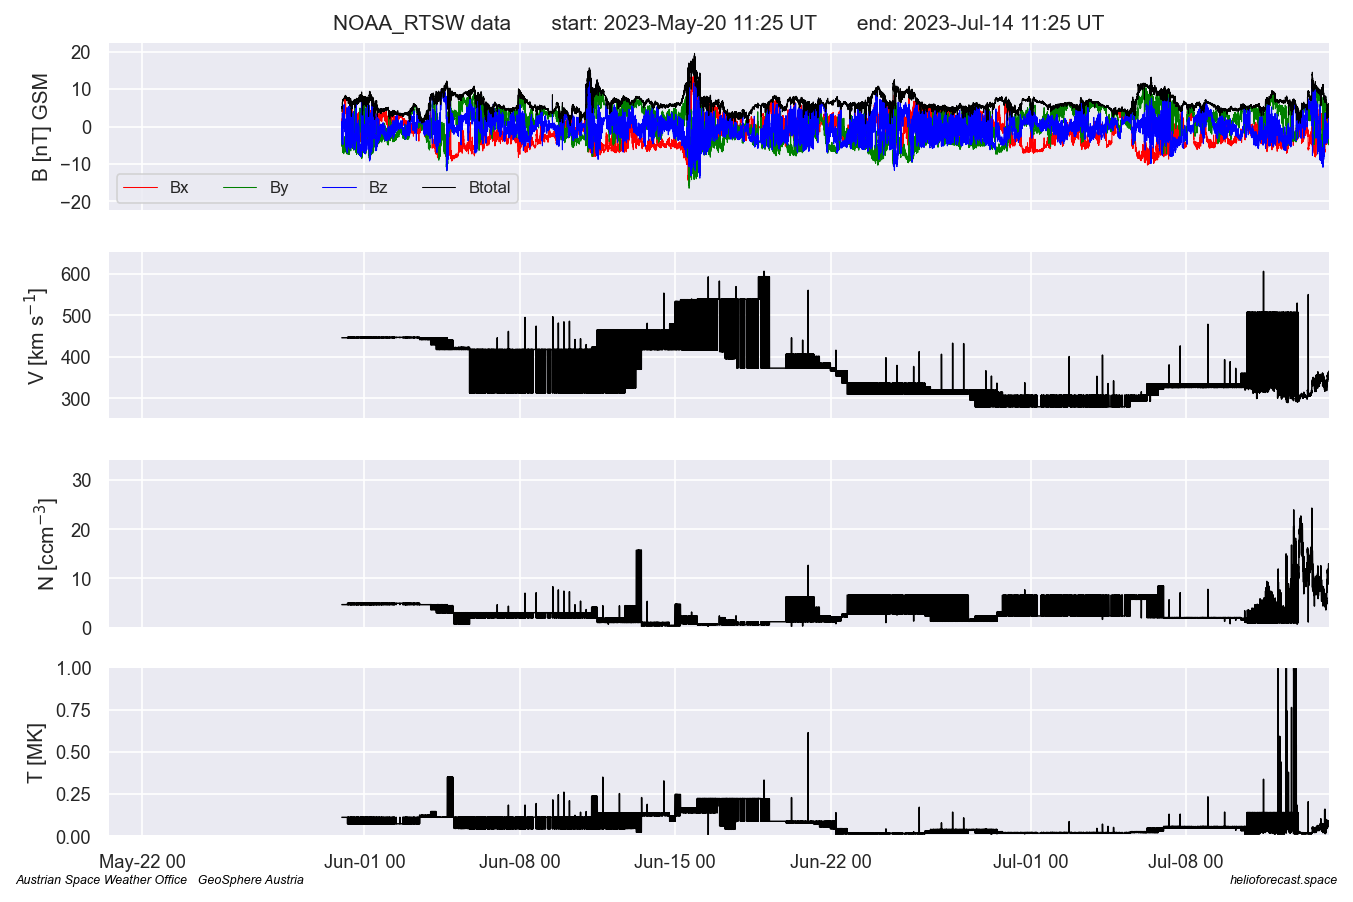

In [6]:
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 

print(' ')
print('------ NOAA real time solar wind data ')

#test execution times
t0 = time.time()


if get_noaa > 0:
    print('download NOAA real time solar wind plasma and mag and dst')
    datestr=str(datetime.datetime.utcnow().strftime("%Y-%m-%d"))
    print(datestr+' UTC')

    plasma='http://services.swpc.noaa.gov/products/solar-wind/plasma-7-day.json'
    mag='http://services.swpc.noaa.gov/products/solar-wind/mag-7-day.json'
    dst='https://services.swpc.noaa.gov/products/kyoto-dst.json'

    try: 
        urllib.request.urlretrieve(plasma, noaa_path+'plasma/plasma-7-day_'+datestr+'.json')
        print(noaa_path+'plasma/plasma-7-day_'+datestr+'.json')
    except urllib.error.URLError as e:
        print(' ', plasma,' ',e.reason)

    try: 
        urllib.request.urlretrieve(mag, noaa_path+'mag/mag-7-day_'+datestr+'.json')
        print(noaa_path+'mag/mag-7-day_'+datestr+'.json')
    except urllib.error.URLError as e:
        print(' ', mag,' ',e.reason)
        

    try: 
        urllib.request.urlretrieve(dst, noaa_path+'dst/dst-7-day_'+datestr+'.json')
        print(noaa_path+'dst/dst-7-day_'+datestr+'.json')
    except urllib.error.URLError as e:
        print(' ', mag,' ',e.reason)
 
    print('NOAA download complete')
    
    
    ######## SAVE NOAA DATA AS PICKLE


    save_noaa=1
    filenoaa='noaa_rtsw_last_300files_now.p'
    # last parameter gives a cutoff, so only the latest N files are taken for the NOAA data pickle file
    if save_noaa > 0: hd.save_noaa_rtsw_data(data_path,noaa_path,filenoaa,300)

    [noaa,hnoaa]=pickle.load(open(data_path+filenoaa, "rb" ) ) 
    print('NOAA RTSW saved as pickle file complete')


else:
    print('NOAA data NOT downloaded and saved as pickle, turn on switch')  
 
#plot
start=datetime.datetime.utcnow() - datetime.timedelta(days=55)
end=datetime.datetime.utcnow() 
hp.plot_insitu_update_noaa_rtsw(noaa, start, end,'NOAA_RTSW',plot_path+'noaa/',now2=True)


t1 = time.time()

print()
print('NOAA download, save as pickle and plotting takes', np.round(t1-t0,2), 'seconds')


    

### Wind data

In [7]:
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 

    
print(' ')
print('------ download Wind data ')


#download data for current year only    
if get_wind > 0:
    hd.wind_download_ascii(start_year=datetime.datetime.utcnow().year, wind_path=wind_path) 
else:
    print('Wind data NOT downloaded, turn on switch')  

    
    
    
#filewin="wind_2018_now_heeq.p" 
#start=datetime.datetime(2022, 12, 1)
#start=datetime.datetime(2022, 12, 1)
#end=datetime.datetime.utcnow()

#hd.save_wind_data_ascii(data_path,filewin,start,end,coord='HEEQ')
#[win,winh]=pickle.load(open(data_path+filewin, "rb"))
#start=win.time[-1]-datetime.timedelta(days=365)
#end=datetime.datetime.utcnow()         
#hp.plot_insitu_update(win, start, end,'Wind',plot_path+'wind/',now=True)



 
------ download Wind data 
downloading Wind ascii data to  /Users/chris/python/data/wind/
for years ['2023']
https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/ascii/1min_ascii/
202301_wind_mag_1min.asc
202302_wind_mag_1min.asc
202303_wind_mag_1min.asc
202304_wind_mag_1min.asc
202305_wind_mag_1min.asc
202306_wind_mag_1min.asc
https://spdf.gsfc.nasa.gov/pub/data/wind/swe/ascii/swe_kp_unspike/
wind_kp_unspike2023.txt


### STEREO-A beacon data

 
------ download STEREO-A beacon data 
 
download STEREO-A beacon data to  /Users/chris/python/data/stereoa/
STA_LB_IMPACT_20230709_V02.cdf
STA_LB_PLASTIC_20230709_V14.cdf
STA_LB_IMPACT_20230710_V02.cdf
STA_LB_PLASTIC_20230710_V14.cdf
STA_LB_IMPACT_20230711_V02.cdf
STA_LB_PLASTIC_20230711_V14.cdf
STA_LB_IMPACT_20230712_V02.cdf
STA_LB_PLASTIC_20230712_V14.cdf
STA_LB_IMPACT_20230713_V02.cdf
STA_LB_PLASTIC_20230713_V14.cdf
STA_LB_IMPACT_20230714_V02.cdf
STA_LB_PLASTIC_20230714_V14.cdf
 
------ process STEREO-A beacon data to pickle
2023-04-05 11:25:00
2023-07-14 11:25:00
['20230405', '20230406', '20230407', '20230408', '20230409', '20230410', '20230411', '20230412', '20230413', '20230414', '20230415', '20230416', '20230417', '20230418', '20230419', '20230420', '20230421', '20230422', '20230423', '20230424', '20230425', '20230426', '20230427', '20230428', '20230429', '20230430', '20230501', '20230502', '20230503', '20230504', '20230505', '20230506', '20230507', '20230508', '20230509', '20

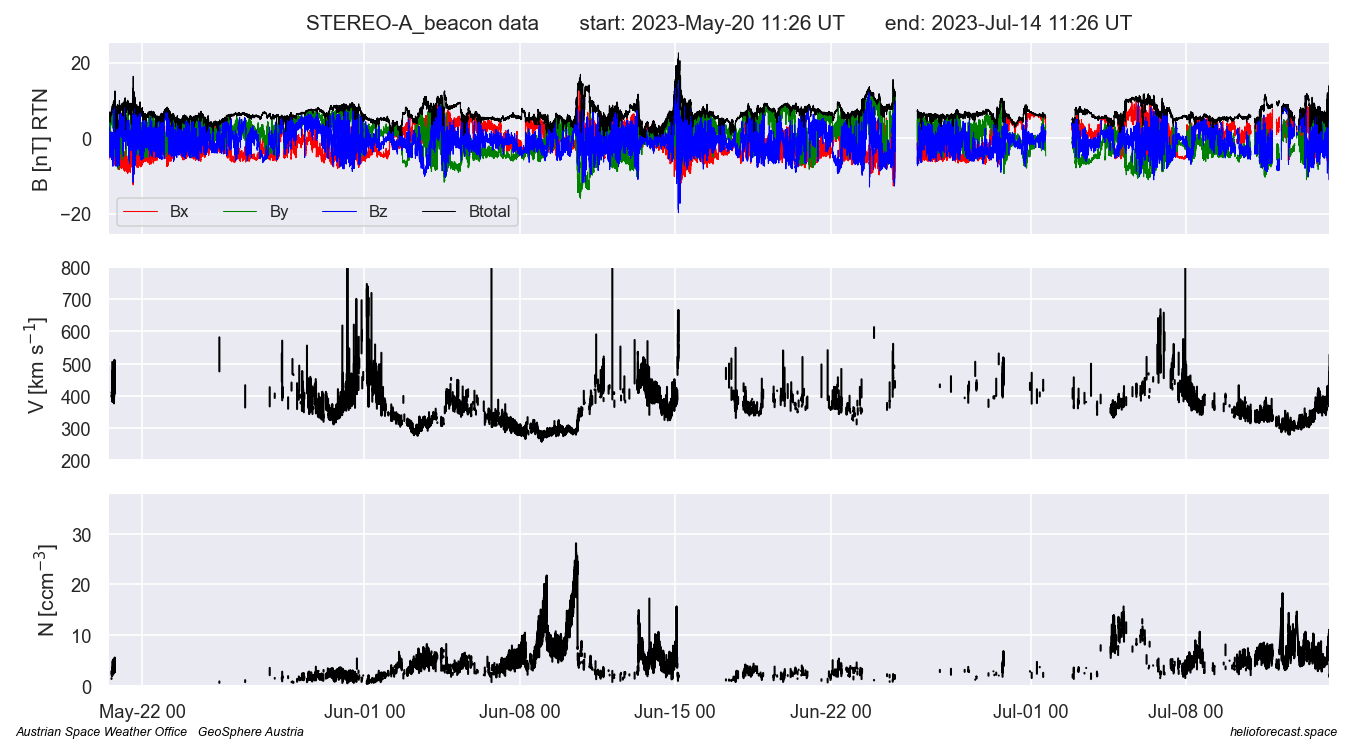

In [8]:
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 

#test execution times
t0 = time.time()


if get_stereoa > 0:
    

    print(' ')
    print('------ download STEREO-A beacon data ')
    print(' ')

    
    hd.stereoa_download_beacon(start_year=datetime.datetime.utcnow().year,start_month=datetime.datetime.utcnow().month,start_day=datetime.datetime.utcnow().day-5,stereoa_path=stereoa_path)   
 
    #hd.stereoa_download_beacon(start_year=datetime.datetime.utcnow().year,start_month=1,start_day=1,stereoa_path=stereoa_path)   

    
    print(' ')
    print('------ process STEREO-A beacon data to pickle') 

    #define filename
    file_sta_beacon='stereoa_beacon_last_100days_now.p'   

    #save pickle file
    hd.save_stereoa_beacon_data(data_path,stereoa_path,file_sta_beacon,datetime.datetime.utcnow()-datetime.timedelta(days=300),datetime.datetime.utcnow(),coord='RTN' )   
    
#load pickle    
[sta,hsta]=pickle.load(open(data_path+file_sta_beacon, "rb" ) )  

#plot
start=datetime.datetime.utcnow() - datetime.timedelta(days=55)
end=datetime.datetime.utcnow() 
hp.plot_insitu_update_stereoa_beacon(sta, start, end,'STEREO-A_beacon',plot_path+'stereoa/',now2=True)
    
    
t1 = time.time()

print()
print('STEREO-A beacon downloading current month, save as pickle last 30 days and plotting takes', np.round(t1-t0,2), 'seconds')
    

In [9]:

t1all = time.time()

print(' ')
print(' ')
print(' ')
print('------------------')
print('Runtime for full data update web code:', np.round((t1all-t0all)/60,2), 'minutes')
print('--------------------------------------------------------------------------------------')



 
 
 
------------------
Runtime for full data update web code: 3.39 minutes
--------------------------------------------------------------------------------------
